### > > > Test notebook < < <
# Synapse placement visualization/validation

In [3]:
import matplotlib.pyplot as plt
import neurom as nm
import numpy as np
import os
from bluepysnap.circuit import Circuit
from bluepysnap.morph import MorphHelper


In [38]:
# Circuit selection
ref_circuit = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/sonata/circuit_config_v2.json'
ref_popul = 'default'
# manip_circuit = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1_manip__TEST_ConnProbAdj10__/circuit_config.json'
# manip_circuit = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1_manip__TEST_ConnProb1stOrd12_KeepReuse__/circuit_config.json'
manip_circuit = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1_NoConn_manip__TEST_Rewiring1stOrd02_/circuit_config.json'
manip_popul = 'All__All__chemical'

In [39]:
# Load circuits
c_ref = Circuit(ref_circuit)
assert ref_popul in c_ref.edges.population_names, f"ERROR: Ref edges population not found (available: {c_ref.edges.population_names})!"
ref_edges = c_ref.edges[ref_popul]
nodes = [ref_edges.source, ref_edges.target]
node_ids = [n.ids() for n in nodes]
ref_edges_table = ref_edges.afferent_edges(node_ids[1], properties=sorted(ref_edges.property_names))

c_manip = Circuit(manip_circuit)
assert manip_popul in c_manip.edges.population_names, f"ERROR: Manip edges population not found (available: {c_manip.edges.population_names})!"
np.testing.assert_array_equal(node_ids[0], ref_edges.source.ids(), f"ERROR: Source nodes mismatch!")
np.testing.assert_array_equal(node_ids[1], ref_edges.target.ids(), f"ERROR: Target nodes mismatch!")
manip_edges = c_manip.edges[manip_popul]
manip_edges_table = manip_edges.afferent_edges(node_ids[1], properties=sorted(manip_edges.property_names))


In [40]:
# Select potential connections to plot
src_sel = {"layer": 4, "synapse_class": "EXC"}
tgt_sel = {"layer": 5, "synapse_class": "EXC"}

node_ids_sel = [nodes[0].ids(src_sel), nodes[1].ids(tgt_sel)]

for _idx, _nm in enumerate(["source", "target"]):
    print(f"INFO: {len(node_ids_sel[_idx])} of {len(node_ids[_idx])} {_nm} nodes selected")

ref_edges_table_sel = ref_edges_table[
    np.logical_and(
        np.isin(ref_edges_table["@source_node"], node_ids_sel[0]),
        np.isin(ref_edges_table["@target_node"], node_ids_sel[1])
    )
]
ref_conns, ref_nsynconn = np.unique(ref_edges_table_sel[["@source_node", "@target_node"]], axis=0, return_counts=True)
ref_tgt, ref_indeg = np.unique(ref_conns[:, 1], axis=0, return_counts=True)

manip_edges_table_sel = manip_edges_table[
    np.logical_and(
        np.isin(manip_edges_table["@source_node"], node_ids_sel[0]),
        np.isin(manip_edges_table["@target_node"], node_ids_sel[1])
    )
]
manip_conns, manip_nsynconn = np.unique(manip_edges_table_sel[["@source_node", "@target_node"]], axis=0, return_counts=True)
manip_tgt, manip_indeg = np.unique(manip_conns[:, 1], axis=0, return_counts=True)

INFO: 866 of 5924 source nodes selected
INFO: 986 of 5924 target nodes selected


In [41]:
# Select target neuron and all ingoing connections
indeg_min = 2
indeg_max = 100
tgt_sel = None
for _tgt, _ind in zip(ref_tgt, ref_indeg):
    if not indeg_min <= _ind <= indeg_max:
        continue
    _msel = np.where(manip_tgt == _tgt)[0]
    if len(_msel) == 0:
        continue
    _msel = _msel[0]
    if indeg_min <= manip_indeg[_msel] <= indeg_max:
    # if indeg_min <= manip_indeg[_msel] <= indeg_max and manip_indeg[_msel] > _ind + 0:
    # if indeg_min <= manip_indeg[_msel] <= indeg_max and manip_indeg[_msel] < _ind - 5:
        tgt_sel = _tgt
        print(f"INFO: Target node {tgt_sel} selected (indeg ref: {_ind}, indeg manip: {manip_indeg[_msel]})")
        break

assert tgt_sel is not None, "ERROR: No target neuron selected!"

ref_syn_all = ref_edges_table[
    ref_edges_table["@target_node"] == tgt_sel
]  # All synapses on target node

ref_syn_sel = ref_edges_table_sel[
    ref_edges_table_sel["@target_node"] == tgt_sel
]  # Synapses on target node from selected source population

manip_syn_all = manip_edges_table[
    manip_edges_table["@target_node"] == tgt_sel
]  # All synapses on target node

manip_syn_sel = manip_edges_table_sel[
    manip_edges_table_sel["@target_node"] == tgt_sel
]  # Synapses on target node from selected source population

INFO: Target node 2745 selected (indeg ref: 4, indeg manip: 4)


In [42]:
# Access target (dendritic) morphology
morph_dir = nodes[1].config['morphologies_dir']
tgt_morph = MorphHelper(morph_dir, nodes[1], {'h5v1': os.path.join(morph_dir, 'h5v1'), 'neurolucida-asc': os.path.join(morph_dir, 'ascii')})
get_tgt_morph = lambda node_id: tgt_morph.get(node_id, transform=True, extension='h5') # Access function (incl. transformation!), using .h5 format

nrn_morph = get_tgt_morph(tgt_sel)  # Target morphology
dd_types = list(filter(lambda tp: "dendrite" in tp.name, nm.NEURITE_TYPES))  # Select dendrite types
dd_sel = np.isin(nrn_morph.section_types, dd_types)
dd_points = [_sec.points for _sel, _sec in zip(dd_sel, nrn_morph.sections) if _sel]  # Dendrite points
soma_pos = nrn_morph.soma.center

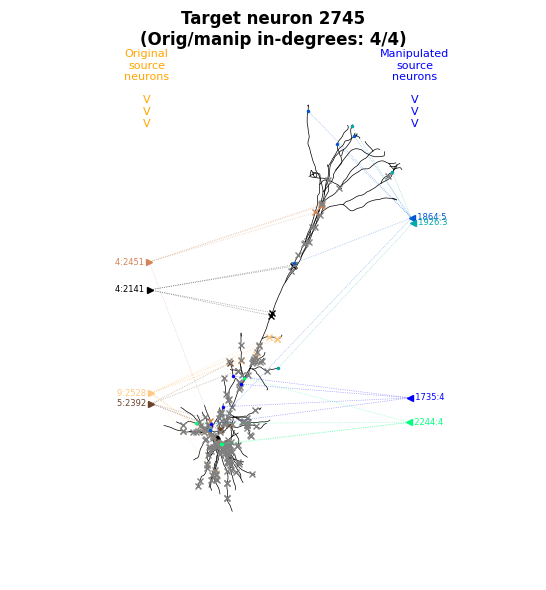

In [43]:
# Plot dendritic morphology & synapce locations
plt.figure(figsize=(6, 6))

plt.subplot(1, 1, 1, projection="3d")

## Plot target morphology
plt.plot(*soma_pos, "ok", alpha=1.0, markeredgecolor="none", label="Soma")
for _i, _p in enumerate(dd_points):
    plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], "-k", lw=0.5, alpha=1.0, label="Dendrite" if not _i else None)

## Plot original synapse locations
src_ids_conn = np.unique(ref_syn_sel["@source_node"])
src_ids_noconn = np.setdiff1d(ref_syn_all["@source_node"], src_ids_conn)
conn_colors = plt.cm.copper(np.linspace(0, 1, len(src_ids_conn)))
noconn_color = "grey"
indeg = [len(src_ids_conn)]

for _sidx, _src in enumerate(src_ids_conn):
    plt.plot(
        ref_syn_sel[ref_syn_sel["@source_node"] == _src]["afferent_center_x"],
        ref_syn_sel[ref_syn_sel["@source_node"] == _src]["afferent_center_y"],
        ref_syn_sel[ref_syn_sel["@source_node"] == _src]["afferent_center_z"],
        "x",
        color=conn_colors[_sidx, :],
        ms=5,
        alpha=1.0,
        # markeredgecolor="none",
        label=f"Src {_src} synapses",
    )

plt.plot(
    ref_syn_all[np.isin(ref_syn_all["@source_node"], src_ids_noconn)]["afferent_center_x"],
    ref_syn_all[np.isin(ref_syn_all["@source_node"], src_ids_noconn)]["afferent_center_y"],
    ref_syn_all[np.isin(ref_syn_all["@source_node"], src_ids_noconn)]["afferent_center_z"],
    "x",
    color=noconn_color,
    ms=5,
    alpha=1.0,
    # markeredgecolor="none",
    label="Remaining synapses",
)

## Fix axis limits
plt.gca().set_xlim(plt.gca().get_xlim())
plt.gca().set_ylim(plt.gca().get_ylim())
plt.gca().set_zlim(plt.gca().get_zlim())

## Plot all ingoing original connections
for _sidx, _src in enumerate(src_ids_conn):
    _syn_sel = ref_syn_sel[ref_syn_sel["@source_node"] == _src]
    p0_x = np.min(plt.gca().get_xlim())
    p0_y = np.mean(_syn_sel["afferent_center_y"])
    p0_z = np.mean(_syn_sel["afferent_center_z"])
    for _, _syn in _syn_sel.iterrows():
        plt.plot(
            [p0_x, _syn["afferent_center_x"]],
            [p0_y, _syn["afferent_center_y"]],
            [p0_z, _syn["afferent_center_z"]],
            ":",
            color=conn_colors[_sidx, :],
            lw=0.5,
            alpha=0.5,
        )
    plt.plot(p0_x, p0_y, p0_z, ">", ms=5, color=conn_colors[_sidx, :])
    plt.gca().text(p0_x, p0_y, p0_z, f"{_syn_sel.shape[0]}:{_src}  ", ha="right", va="center", color=conn_colors[_sidx, :], fontsize=6)
plt.gca().text(np.min(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"Original\nsource\nneurons\n\nV\nV\nV\n\n", ha="center", va="center", color="orange", fontsize=8)

## Plot manipulated synapse locations
src_ids_conn = np.unique(manip_syn_sel["@source_node"])
conn_colors = plt.cm.winter(np.linspace(0, 1, len(src_ids_conn)))
indeg.append(len(src_ids_conn))

for _sidx, _src in enumerate(src_ids_conn):
    plt.plot(
        manip_syn_sel[manip_syn_sel["@source_node"] == _src]["afferent_center_x"],
        manip_syn_sel[manip_syn_sel["@source_node"] == _src]["afferent_center_y"],
        manip_syn_sel[manip_syn_sel["@source_node"] == _src]["afferent_center_z"],
        ".",
        color=conn_colors[_sidx, :],
        ms=5,
        alpha=1.0,
        markeredgecolor="none",
        label=f"Src {_src} synapses",
    )

## Plot all ingoing manipulated connections
for _sidx, _src in enumerate(src_ids_conn):
    _syn_sel = manip_syn_sel[manip_syn_sel["@source_node"] == _src]
    p0_x = np.max(plt.gca().get_xlim())
    p0_y = np.mean(_syn_sel["afferent_center_y"])
    p0_z = np.mean(_syn_sel["afferent_center_z"])
    for _, _syn in _syn_sel.iterrows():
        plt.plot(
            [p0_x, _syn["afferent_center_x"]],
            [p0_y, _syn["afferent_center_y"]],
            [p0_z, _syn["afferent_center_z"]],
            ":",
            color=conn_colors[_sidx, :],
            lw=0.5,
            alpha=0.5,
        )
    plt.plot(p0_x, p0_y, p0_z, "<", ms=5, color=conn_colors[_sidx, :])
    plt.gca().text(p0_x, p0_y, p0_z, f"  {_src}:{_syn_sel.shape[0]}", ha="left", va="center", color=conn_colors[_sidx, :], fontsize=6)
plt.gca().text(np.max(plt.gca().get_xlim()), np.min(plt.gca().get_ylim()), np.max(plt.gca().get_zlim()), f"Manipulated\nsource\nneurons\n\nV\nV\nV\n\n", ha="center", va="center", color="blue", fontsize=8)

## Mark synapses with idential (physiological) parameter values (i.e. all except @source/target_node; special case: delay)
param_sel = manip_syn_sel.columns[~np.isin(manip_syn_sel.columns, ["@source_node", "@target_node"])]
param_subsel = manip_syn_sel.columns[~np.isin(manip_syn_sel.columns, ["@source_node", "@target_node", "delay"])]
for _sidx, _src in enumerate(src_ids_conn):
    _syn_param = manip_syn_sel[param_sel][manip_syn_sel["@source_node"] == _src]
    for _, _sp in _syn_param.iterrows():
        found_idx = np.where(np.all(ref_syn_sel[param_subsel] == _sp[param_subsel], 1))[0]
        if len(found_idx) == 0:
            pass
        elif len(found_idx) == 1:
            found_idx = found_idx[0]
            if ref_syn_sel.iloc[found_idx]["delay"] == _sp["delay"]:  # Delay identical too
                marker = "o"
            else:
                marker = "s"
            plt.plot(
                _sp["afferent_center_x"],
                _sp["afferent_center_y"],
                _sp["afferent_center_z"],
                marker,
                color="none",
                markeredgecolor=conn_colors[_sidx, :],
                markeredgewidth=1,
                ms=10,
                alpha=0.5,
            )
        else:
            assert False, "ERROR: Multiple identical entries found!"

plt.title(f"Target neuron {tgt_sel}\n(Orig/manip in-degrees: {'/'.join([str(_in) for _in in indeg])})", fontweight="bold")
plt.gca().set_xlabel("x")
plt.gca().set_ylabel("y")
plt.gca().set_zlabel("z")

plt.gca().view_init(0, -90)
plt.axis("image")
plt.axis("off")

plt.tight_layout()
# plt.savefig(f"rewiring_neuron{tgt_sel}_<SPEC>.png", dpi=300)
plt.show()

In [ ]:
# # Select one specific connection
# nsynconn_th = 10
# conn_sel = []

# for _conn, _nsynconn in zip(ref_conns, ref_nsynconn):
#     if _nsynconn < nsynconn_th:
#         continue
#     _sel = np.where(np.all(manip_conns == _conn, 1))[0]
#     if len(_sel) == 0:
#         continue
#     _sel = _sel[0]
#     if manip_nsynconn[_sel] > nsynconn_th:
#         conn_sel = _conn
#         print(f"INFO: Connection {conn_sel} selected (#syn ref: {_nsynconn}, #syn manip: {manip_nsynconn[_sel]})")
#         break

# ref_syn = ref_edges_table_sel[
#     np.logical_and(
#         ref_edges_table_sel["@source_node"] == conn_sel[0],
#         ref_edges_table_sel["@target_node"] == conn_sel[1]
#     )
# ]

# ref_syn_sel = ref_edges_table_sel[
#     ref_edges_table_sel["@target_node"] == conn_sel[1]
# ]

# ref_syn_all = ref_edges_table[
#     ref_edges_table["@target_node"] == conn_sel[1]
# ]

# manip_syn = manip_edges_table_sel[
#     np.logical_and(
#         manip_edges_table_sel["@source_node"] == conn_sel[0],
#         manip_edges_table_sel["@target_node"] == conn_sel[1]
#     )
# ]